<h2>Определение пауз</h2>
Алгоритм:

  1. Вычисляем интенсивность сигнала
  2. Интервалы выше порога определяем как речевые, ниже - как паузы
  3. Объединяем речевые и неречевые интервалы
  4. Удаляем короткие паузы (скорее всего, это смычные согласные)
  5. Удаляем короткие звучащие сегменты (это не речевые звуки)
  6. Пишем seg

In [9]:
!wget https://raw.githubusercontent.com/phonetics-spbu/phonetics-spbu.github.io/main/public/courses/linear_models/files/s18-27s.wav

--2025-11-27 08:09:39--  https://raw.githubusercontent.com/phonetics-spbu/phonetics-spbu.github.io/main/public/courses/linear_models/files/s18-27s.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3675562 (3.5M) [audio/wav]
Saving to: ‘s18-27s.wav.2’

s18-27s.wav.2       100%[===================>]   3.50M  --.-KB/s    in 0.07s   

2025-11-27 08:09:39 (51.9 MB/s) - ‘s18-27s.wav.2’ saved [3675562/3675562]



In [10]:
from itertools import product

letters = "GBRY"
nums = "1234"
levels = [ch + num for num, ch in product(nums, letters)]
level_codes = [2 ** i for i in range(len(levels))]

level2code = {i: j for i, j in zip(levels, level_codes)}
code2level = {j: i for i, j in zip(levels, level_codes)}

class Params:

    def __init__(self, samplerate, sampwidth, num_channels):
        self.samplerate = samplerate
        self.sampwidth = sampwidth
        self.num_channels = num_channels

class Label:

    def __init__(self, position, name, level):
        self.position = position
        self.name = name
        self.level = level

class Seg:
    def __init__(self, filename, labels=[], params=Params(0, 0, 0)):
        self.filename = filename
        self.labels = labels
        self.params = params

    def detect_encoding(self) -> str:
        encoding = "utf-8"
        try:
            text = open(self.filename, 'r', encoding="utf-8").read()
        except UnicodeDecodeError:
            try:
                open(self.filename, 'r', encoding="utf-16").read()
                encoding = "utf-16"
            except UnicodeError:
                encoding = "cp1251"
        else:
            if text.startswith("\ufeff"):  # т.н. byte order mark
                encoding = "utf-8-sig"
        return encoding


    def read_seg(self) -> tuple[dict, list[dict]]:
        with open(self.filename, encoding=self.detect_encoding()) as f:
            lines = [line.strip() for line in f.readlines()]

        # найдём границы секций в списке строк:
        header_start = lines.index("[PARAMETERS]") + 1
        data_start = lines.index("[LABELS]") + 1

        # прочитаем параметры
        params = {}
        for line in lines[header_start:data_start - 1]:
            key, value = line.split("=")
            params[key] = int(value)

        self.params = Params(
            params["SAMPLING_FREQ"],
            params["BYTE_PER_SAMPLE"],
            params["N_CHANNEL"]
        )

        # прочитаем метки
        labels = []
        for line in lines[data_start:]:
            # если в строке нет запятых, значит, это не метка и метки закончились
            if line.count(",") < 2:
                break
            pos, level, name = line.split(",", maxsplit=2)
            label = Label(
                int(pos) // params["BYTE_PER_SAMPLE"] // params["N_CHANNEL"],
                name,
                code2level[int(level)]
            )
            labels.append(label)

        self.labels = labels

    def write_seg_file(self):
        params = {
            "SAMPLING_FREQ": self.params.samplerate,
            "BYTE_PER_SAMPLE": self.params.sampwidth,
            "CODE": 0,
            "N_CHANNELS": self.params.num_channels,
            "N_LABEL": len(self.labels)
        }
        with open(self.filename, "w", encoding="utf-8") as f:
            f.write("[PARAMETERS]\n")
            for key in params.keys():
                f.write(f"{key}={str(params[key])}\n")
            f.write("[LABELS]\n")
            for label in self.labels:
                pos = label.position * self.params.num_channels * self.params.sampwidth
                print(f"{pos}, {level2code[label.level]}, {label.name}\n")
                f.write(f"{pos}, {level2code[label.level]}, {label.name}\n")

In [11]:
import wave
import struct

sampwidth_to_char = {1: "c", 2: "h", 4: "i"}

In [12]:
class Signal:
  def __init__(self, filename: str, signal: list = [], params: Params = None, seg: Seg = None):
    self.signal: list = signal
    self.filename: str = filename
    self.seg: Seg = seg
    self.params: Params = params

  def init_params(self):
    if self.params is not None:
      return
    if self.seg is not None:
      self.seg.init_params()
      self.params = self.seg.params
    else:
      default_params = Params(22050, 2, 1)
      self.params = default_params

  def read_wav(self):
    try:
      f = wave.open(self.filename)
    except FileNotFoundError:
      print(self.filename, " не найден")

    num_samples = f.getnframes()
    samplerate = f.getframerate()
    sampwidth = f.getsampwidth()
    num_channels = f.getnchannels()

    sampwidth_to_char = {1: "c", 2: "h", 4: "i"}
    fmt = str(num_samples * num_channels) + sampwidth_to_char[sampwidth]

    signal = struct.unpack(fmt, f.readframes(num_samples * num_channels))
    self.signal = signal
    new_params = Params(samplerate, sampwidth, num_channels)
    self.params = new_params

  def read_sbl(self):
    with open(self.filename, "rb") as f:
      raw_signal = f.read()
    num_samples = len(raw_signal) // self.params.sampwidth
    fmt = str(num_samples) + sampwidth_to_char[self.params.sampwidth]
    signal = struct.unpack(fmt, raw_signal)
    self.signal = signal

  def read_sound_file(self):
    self.init_params()
    if self.filename.endswith(".wav"):
        self.read_wav()
    elif self.filename.endswith(".sbl"):
        self.read_sbl()
    else:
        raise ValueError("Неизвестное расширение, ", self.filename)

  def write_wav_file(self):
    num_samples = self.params.samplerate * 2
    sampwidth_to_char = {1: "c", 2: "h", 4: "i"}
    fmt = str(num_samples) + sampwidth_to_char[self.params.sampwidth]

    signal_ = struct.pack(fmt, *self.signal)

    f = wave.open(self.filename, "wb")
    f.setnchannels(self.params.numchannels)
    f.setsampwidth(self.params.sampwidth)
    f.setframerate(self.params.samplerate)
    f.writeframes(signal_)
    f.close()


In [13]:
!wget https://raw.githubusercontent.com/phonetics-spbu/phonetics-spbu.github.io/main/public/courses/linear_models/files/s18-27s.wav

--2025-11-27 08:09:39--  https://raw.githubusercontent.com/phonetics-spbu/phonetics-spbu.github.io/main/public/courses/linear_models/files/s18-27s.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3675562 (3.5M) [audio/wav]
Saving to: ‘s18-27s.wav.3’

s18-27s.wav.3       100%[===================>]   3.50M  --.-KB/s    in 0.07s   

2025-11-27 08:09:39 (51.5 MB/s) - ‘s18-27s.wav.3’ saved [3675562/3675562]



In [14]:
filename = r"s18-27s.wav"
seg_filename = r"s18-27s.seg"

In [15]:
wav_signal = Signal(filename)
wav_signal.read_sound_file()

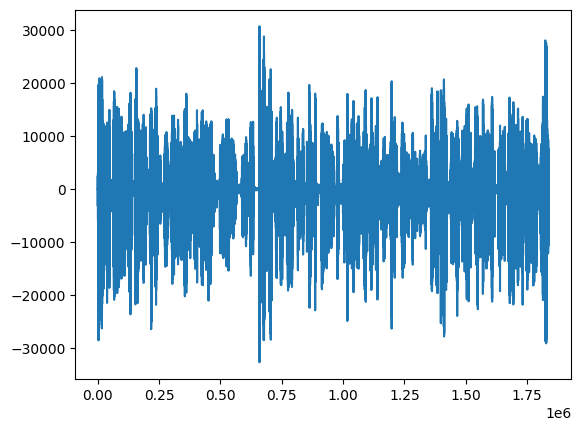

In [16]:
import matplotlib.pyplot as plt

plt.plot(wav_signal.signal)

In [51]:
import numpy as np

def detect_pauses(sig: Signal, window_size: float, threshold: float, min_pause_duration: float, min_alloph_duration: float):
    """
    sig - сигнал
    window_size - размер фрейма в сек
    """
    sr = sig.params.samplerate
    N_window = int(window_size * sr) # размер фрейма в отсчетах

    num_windows = len(sig.signal) // N_window
    intensity_list = []

    for i in range(num_windows):
        start = i * N_window
        end = start + N_window
        frame = np.array(wav_signal.signal[start : end])
        rms = np.sqrt(np.mean(frame**2))
        intensity_list.append(rms)

    max_intensity = max(intensity_list)
    labels = []

    for i, intens in enumerate(intensity_list):
        if intens / max_intensity > threshold:
            labels.append(Label(i * N_window, f"voice", "B1"))
        else:
            labels.append(Label(i * N_window, f"pause", "B1"))

    labels_united = [labels[0]]
    for label1, label2 in zip(labels, labels[1:]):
        if label1.name != label2.name:
            labels_united.append(label2)

    n = 1
    labels_stops_deleted = []
    indexes_to_delete = []
    for label1, label2 in zip(labels_united[1:], labels_united[2:]):
      if (label1.name == "pause" and (label2.position - label1.position) / sig.params.samplerate < min_pause_duration):
          indexes_to_delete.append(n)
          indexes_to_delete.append(n + 1)
      n += 1

    for i, label in enumerate(labels_united):
      if i not in indexes_to_delete:
        labels_stops_deleted.append(label)

    new_seg_fn = seg_filename
    new_seg = Seg(new_seg_fn, labels_stops_deleted, sig.params)
    new_seg.write_seg_file()


In [52]:
detect_pauses(wav_signal, 0.02, 0.02, 0.1, 0.05)

0, 2, voice

102400, 2, pause

113920, 2, voice

119040, 2, pause

125440, 2, voice

282880, 2, pause

290560, 2, voice

291840, 2, pause

300800, 2, voice

399360, 2, pause

407040, 2, voice

416000, 2, pause

423680, 2, voice

513280, 2, pause

523520, 2, voice

535040, 2, pause

541440, 2, voice

957440, 2, pause

967680, 2, voice

980480, 2, pause

989440, 2, voice

1132800, 2, pause

1153280, 2, voice

1154560, 2, pause

1168640, 2, voice

1231360, 2, pause

1239040, 2, voice

1274880, 2, pause

1314560, 2, voice

1602560, 2, pause

1611520, 2, voice

1619200, 2, pause

1628160, 2, voice

1679360, 2, pause

1687040, 2, voice

1694720, 2, pause

1703680, 2, voice

1781760, 2, pause

1794560, 2, voice

1807360, 2, pause

1818880, 2, voice

1926400, 2, pause

1946880, 2, voice

1967360, 2, pause

1982720, 2, voice

1984000, 2, pause

1998080, 2, voice

2443520, 2, pause

2456320, 2, voice

2680320, 2, pause

2691840, 2, voice

2708480, 2, pause

2714880, 2, voice

2848000, 2, pause

